# Exploratory Data Analysis - GitHub Repositories

This notebook analyzes the 500 scraped GitHub repositories to understand:
- Data quality and completeness
- Distribution of languages, topics, and popularity metrics
- Text field characteristics
- Potential data preprocessing needs


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


In [3]:
# Load data from database
import sys
sys.path.append('../src')

from infrastructure.postgres.database import SessionLocal
from domain.models.schema import Project

# Connect to database and load all projects
db = SessionLocal()
try:
    projects = db.query(Project).all()
    print(f"Loaded {len(projects)} projects from database")
finally:
    db.close()

# Convert to DataFrame
df = pd.DataFrame([{
    'id': p.id,
    'title': p.title,
    'description': p.description,
    'readme': p.readme,
    'language': p.language,
    'topics': p.topics,
    'html_url': p.html_url,
    'stargazers_count': p.stargazers_count,
    'forks_count': p.forks_count,
    'open_issues_count': p.open_issues_count,
    'pushed_at': p.pushed_at,
    'created_at': p.created_at
} for p in projects])

print(f"DataFrame shape: {df.shape}")
df.head()


Loaded 494 projects from database
DataFrame shape: (494, 12)


,id,title,description,readme,language,topics,html_url,stargazers_count,forks_count,open_issues_count,pushed_at,created_at
0,7440612b-7c1b-4514-993f-9ac73366979b,MaxRobinsonTheGreat/LifeEngine,The Life Engine,"This is the readme for my evolution simulator,...",JavaScript,"simulation,evolutionary-algorithms",https://github.com/MaxRobinsonTheGreat/LifeEngine,500,121,20,2024-09-08 23:27:51+00:00,2025-07-10 14:57:57.811660+00:00
1,6c2b5dad-6fd2-4461-a988-b31cb98397ea,lodash/lodash,A modern JavaScript utility library delivering...,# lodash v4.17.21\n\n[Site](https://lodash.com...,JavaScript,"lodash,utilities,javascript,modules",https://github.com/lodash/lodash,60724,7064,114,2024-12-12 22:27:04+00:00,2025-07-10 14:57:57.811669+00:00
2,c7683120-345b-466a-bcda-2d9e2446c173,awolfly9/IPProxyTool,python ip proxy tool scrapy crawl. 抓取大量免费代理 i...,# IPProxyTool\n使用 scrapy 爬虫抓取代理网站，获取大量的免费代理 ip...,Python,"proxy,python,ipproxy",https://github.com/awolfly9/IPProxyTool,1994,416,12,2022-12-08 07:42:07+00:00,2025-07-10 14:57:57.811672+00:00
3,03cddb99-5d46-47bf-9132-0ca82adb9702,jesolem/PCV,Open source Python module for computer vision,## About PCV\nPCV is a pure Python library for...,Python,,https://github.com/jesolem/PCV,1946,679,27,2020-12-28 00:44:46+00:00,2025-07-10 14:57:57.811676+00:00
4,3200945d-d14e-4b84-b15b-1210f963b783,trycua/cua,c/ua is the Docker Container for Computer-Use ...,"<div align=""center"">\n <picture>\n <source...",Python,"apple,cua,lume,macos,virtualization,virtualiza...",https://github.com/trycua/cua,8941,404,58,2025-07-09 23:53:08+00:00,2025-07-10 14:57:57.811679+00:00


## 1. Data Overview & Quality Assessment


In [4]:
# Basic info about the dataset
print("Dataset Info:")
print(f"Total repositories: {len(df)}")
print(f"Features: {df.shape[1]}")
print("\nData types:")
print(df.dtypes)
print("\nMemory usage:")
print(df.memory_usage(deep=True).sum() / 1024**2, "MB")


Dataset Info:
Total repositories: 494
Features: 12

Data types:
id                                object
title                             object
description                       object
readme                            object
language                          object
topics                            object
html_url                          object
stargazers_count                   int64
forks_count                        int64
open_issues_count                  int64
pushed_at            datetime64[ns, UTC]
created_at           datetime64[ns, UTC]
dtype: object

Memory usage:
11.930130004882812 MB


Missing Values Summary:
             Missing Count  Missing Percentage
description             12            2.429150
language                 5            1.012146


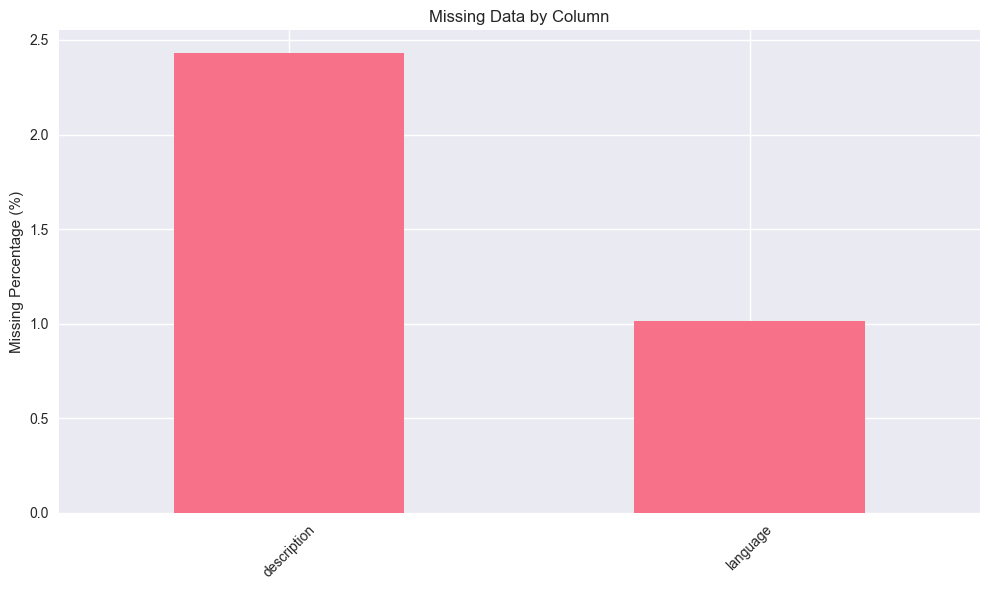

In [5]:
# Missing values analysis
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("Missing Values Summary:")
print(missing_df)

# Visualize missing data
if not missing_df.empty:
    plt.figure(figsize=(10, 6))
    missing_df['Missing Percentage'].plot(kind='bar')
    plt.title('Missing Data by Column')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values found!")


## 2. Programming Languages Distribution


Top 15 Programming Languages:
language
Python        85
TypeScript    84
JavaScript    83
Go            78
Rust          74
Java          72
C              3
C++            2
Swift          1
Julia          1
CSS            1
PHP            1
R              1
Vim Script     1
HTML           1
Name: count, dtype: int64


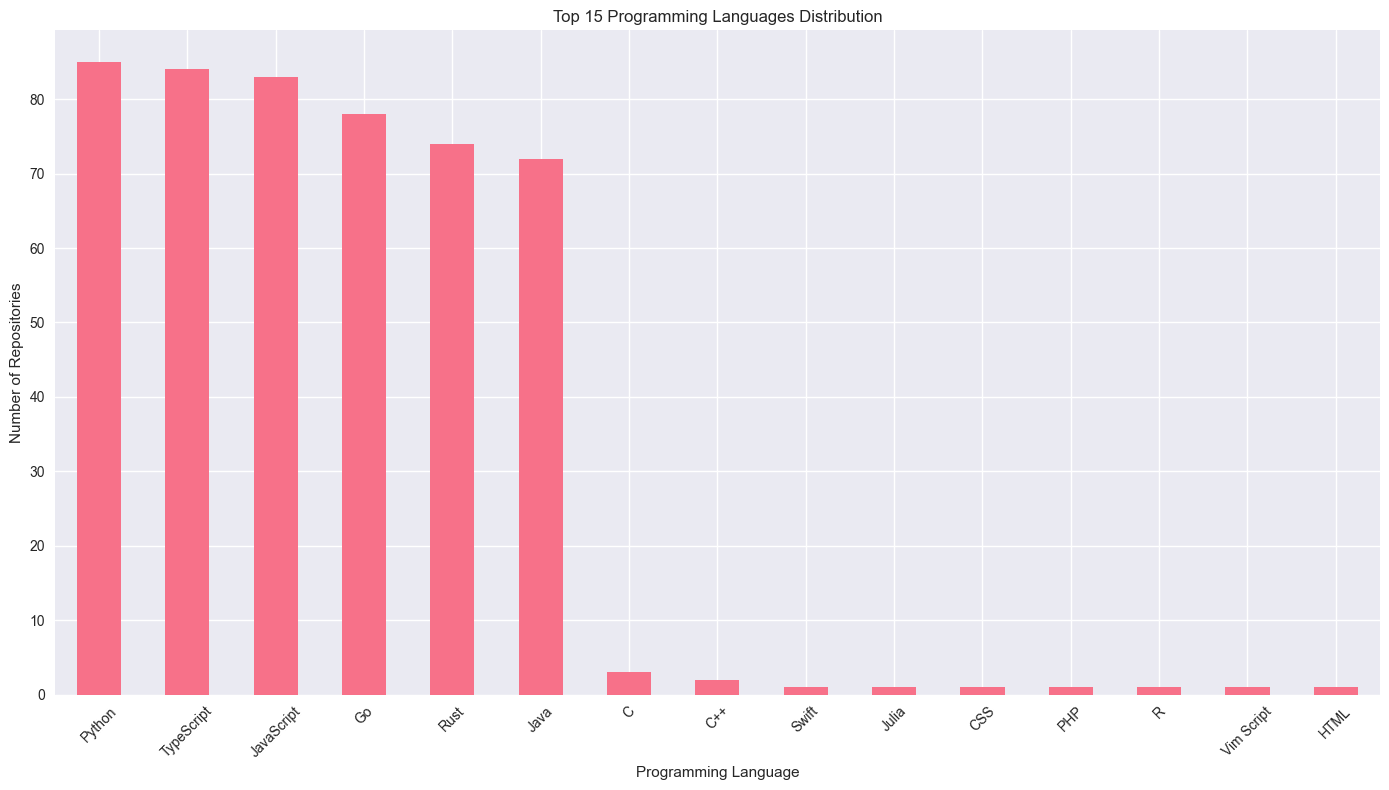


Language Diversity Metrics:
Total unique languages: 16
Top 5 languages represent: 81.8% of repositories


In [6]:
# Language distribution
language_counts = df['language'].value_counts()
print("Top 15 Programming Languages:")
print(language_counts.head(15))

# Plot language distribution
plt.figure(figsize=(14, 8))
language_counts.head(15).plot(kind='bar')
plt.title('Top 15 Programming Languages Distribution')
plt.xlabel('Programming Language')
plt.ylabel('Number of Repositories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Language diversity metrics
total_languages = df['language'].nunique()
top_5_lang_percent = (language_counts.head(5).sum() / len(df)) * 100
print(f"\nLanguage Diversity Metrics:")
print(f"Total unique languages: {total_languages}")
print(f"Top 5 languages represent: {top_5_lang_percent:.1f}% of repositories")


In [ ]:
# Topics analysis
all_topics = []
topics_per_repo = []

for topics_str in df['topics'].dropna():
    if topics_str and str(topics_str).strip():
        topics_list = [topic.strip() for topic in str(topics_str).split(',')]
        topics_list = [topic for topic in topics_list if topic]  # Remove empty strings
        all_topics.extend(topics_list)
        topics_per_repo.append(len(topics_list))
    else:
        topics_per_repo.append(0)

# Add remaining repos with no topics
topics_per_repo.extend([0] * (len(df) - len(topics_per_repo)))

topics_counter = Counter(all_topics)
print(f"Total unique topics: {len(topics_counter)}")
print(f"Average topics per repository: {np.mean(topics_per_repo):.2f}")
print(f"Repositories with no topics: {topics_per_repo.count(0)}")

print("\nTop 10 Most Common Topics:")
for topic, count in topics_counter.most_common(10):
    print(f"{topic}: {count}")


In [ ]:
# Final assessment and recommendations
print("=== DATA QUALITY ASSESSMENT ===")
print()

# 1. Missing/Empty data
print("1. MISSING/EMPTY DATA:")
for field in ['description', 'readme', 'topics', 'language']:
    null_count = df[field].isnull().sum()
    empty_count = (df[field].astype(str).str.strip() == '').sum()
    total_missing = null_count + empty_count
    percentage = (total_missing / len(df)) * 100
    print(f"   {field}: {total_missing} missing ({percentage:.1f}%)")

print()

# 2. Data distribution issues
print("2. DATA DISTRIBUTION:")
print(f"   Language concentration: Top 5 languages = {top_5_lang_percent:.1f}% of data")
print(f"   Repositories with no topics: {topics_per_repo.count(0)} ({(topics_per_repo.count(0)/len(df)*100):.1f}%)")
print(f"   Star distribution: Median = {df['stargazers_count'].median()}, Mean = {df['stargazers_count'].mean():.0f}")

print()

# 3. Recommendations
print("3. PREPROCESSING RECOMMENDATIONS:")
print("   ✓ Handle missing descriptions/readmes (fill with title or remove)")
print("   ✓ Standardize topics format (split, clean, lowercase)")
print("   ✓ Consider log-scaling for star counts (highly skewed)")
print("   ✓ Text cleaning: remove special chars, normalize whitespace")
print("   ✓ Language balancing: consider sampling to reduce dominance")

if top_5_lang_percent > 80:
    print("   ⚠️  HIGH LANGUAGE CONCENTRATION - Consider data balancing")
    
if topics_per_repo.count(0) > len(df) * 0.3:
    print("   ⚠️  MANY REPOS WITHOUT TOPICS - Consider topic extraction from descriptions")

print()
print("=== DATASET READINESS FOR ML ===")
print("✅ Sufficient size for initial training (500 repos)")
print("✅ Good text features available for TF-IDF")
print("✅ Numerical features for scaling")
print("📈 Recommendation: Scale to 1500-2000 repos for better quality")
